In [1]:
# Installing the PyDrive in Python Environment in Colab
!pip install -U -q PyDrive
!pip install tqdm

# Importing the necessary libraries for google drive authentication
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [0]:
# Authenticate to google drive
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

def get_drive_access(drive_link, filename):
  """
  Loads a drive file into local storage for access. Once this method is called,
  a file can be accessed as if it were a local file.

  drive_link: the url of the file on google drive
  filename: the file's filename
  """
  drive_id = drive_link.split('=')[1]
  downloaded = drive.CreateFile({'id':drive_id })
  downloaded.GetContentFile(filename)

In [0]:
import sqlalchemy
import pandas as pd
import numpy as np
import sklearn
import gzip
import datetime
from tqdm import tqdm

In [0]:
db_link = 'https://drive.google.com/open?id=1Fcq2Xz1iWqkYrPSlgIx4ibMmAxZfth7a'
db_filename = "fpa_fod.sqlite"
get_drive_access(db_link, db_filename)

engine = sqlalchemy.create_engine('sqlite:///./fpa_fod.sqlite')
conn = engine.connect()

In [5]:
df = pd.read_sql_query("SELECT FIRE_YEAR,CONT_DATE,STAT_CAUSE_DESCR,LATITUDE,LONGITUDE,STATE,DISCOVERY_DATE,FIRE_SIZE FROM 'Fires'", conn)
print(df.head()) #check the data

   FIRE_YEAR  CONT_DATE STAT_CAUSE_DESCR  ...  STATE  DISCOVERY_DATE FIRE_SIZE
0       2005  2453403.5    Miscellaneous  ...     CA       2453403.5      0.10
1       2004  2453137.5        Lightning  ...     CA       2453137.5      0.25
2       2004  2453156.5   Debris Burning  ...     CA       2453156.5      0.10
3       2004  2453189.5        Lightning  ...     CA       2453184.5      0.10
4       2004  2453189.5        Lightning  ...     CA       2453184.5      0.10

[5 rows x 8 columns]


In [0]:
def convert(df):
  epoch = pd.to_datetime(0, unit='s').to_julian_date()
  df['CONT_DATE'] = pd.to_datetime(df['CONT_DATE'] - epoch, unit='D')
  df['DISCOVERY_DATE'] = pd.to_datetime(df['DISCOVERY_DATE'] - epoch, unit = 'D')
  df['FIRE_DURATION'] = df['CONT_DATE'] - df['DISCOVERY_DATE']
  df['FIRE_DURATION'] = df['FIRE_DURATION'].dt.days
  df['FIRE_DURATION'].fillna(df['FIRE_DURATION'].mean(),inplace = True)
  df['FIRE_DURATION'] = df['FIRE_DURATION'].apply(lambda x : int(x))
  return(df)

In [7]:
dfl2 = pd.read_sql_query("SELECT * FROM 'Fires' LIMIT 10000", conn)
print(list(dfl2.columns))

['OBJECTID', 'FOD_ID', 'FPA_ID', 'SOURCE_SYSTEM_TYPE', 'SOURCE_SYSTEM', 'NWCG_REPORTING_AGENCY', 'NWCG_REPORTING_UNIT_ID', 'NWCG_REPORTING_UNIT_NAME', 'SOURCE_REPORTING_UNIT', 'SOURCE_REPORTING_UNIT_NAME', 'LOCAL_FIRE_REPORT_ID', 'LOCAL_INCIDENT_ID', 'FIRE_CODE', 'FIRE_NAME', 'ICS_209_INCIDENT_NUMBER', 'ICS_209_NAME', 'MTBS_ID', 'MTBS_FIRE_NAME', 'COMPLEX_NAME', 'FIRE_YEAR', 'DISCOVERY_DATE', 'DISCOVERY_DOY', 'DISCOVERY_TIME', 'STAT_CAUSE_CODE', 'STAT_CAUSE_DESCR', 'CONT_DATE', 'CONT_DOY', 'CONT_TIME', 'FIRE_SIZE', 'FIRE_SIZE_CLASS', 'LATITUDE', 'LONGITUDE', 'OWNER_CODE', 'OWNER_DESCR', 'STATE', 'COUNTY', 'FIPS_CODE', 'FIPS_NAME', 'Shape']


In [0]:
dfl2 = convert(dfl2)
df = convert(df)

In [9]:
print(dfl2[["CONT_DATE", "DISCOVERY_DATE", "STATE", "COUNTY", "FIPS_CODE", "FIPS_NAME"]])

      CONT_DATE DISCOVERY_DATE STATE COUNTY FIPS_CODE  FIPS_NAME
0    2005-02-02     2005-02-02    CA     63       063     Plumas
1    2004-05-12     2004-05-12    CA     61       061     Placer
2    2004-05-31     2004-05-31    CA     17       017  El Dorado
3    2004-07-03     2004-06-28    CA      3       003     Alpine
4    2004-07-03     2004-06-28    CA      3       003     Alpine
...         ...            ...   ...    ...       ...        ...
9995 2006-08-08     2006-08-07    CA     93       093   Siskiyou
9996 2006-08-08     2006-08-07    CA     93       093   Siskiyou
9997 2006-08-06     2006-08-06    OR     35       035    Klamath
9998 2006-07-26     2006-07-23    OR     19       019    Douglas
9999 2006-08-11     2006-08-08    CA     93       093   Siskiyou

[10000 rows x 6 columns]


In [43]:
# Load station data into memory
station_link = 'https://drive.google.com/open?id=1loqhXTyhpgm8GMjdAOpuKcoIWEOBfgWx'
station_filename = 'ghcnd-stations.txt'
get_drive_access(station_link, station_filename)
station_df = pd.read_csv(station_filename, header=None, delimiter="\t", names = ['station_id', 'lat', 'long', ''])
station_df = station_df[['station_id', 'lat', 'long']]
station_df = station_df[station_df['station_id'].str.contains("US")]
print(station_df.head())

precip_files = [#('https://drive.google.com/open?id=1wwK97X8F4xrddxIiLc23jhT0qq5Zrgfa', '1992.csv.gz'),
                #('https://drive.google.com/open?id=1a5Fveq3ThnCcrh7-rfc6onEZ5VSvFd1v', '1993.csv.gz'),
                #('https://drive.google.com/open?id=175KezgsyUiM-nK0HZlUeJzf-29_V-fLJ', '1994.csv.gz'),
                #('https://drive.google.com/open?id=1eCwvjED4NRIBnDu2AvTI9CeiPyaloWRQ', '1995.csv.gz'),
                #('https://drive.google.com/open?id=1SV59vfArbsaSw5KdFKzLpxCYEDlxOa6a', '1996.csv.gz'),

                #('https://drive.google.com/open?id=1XjbJgFAjxzxYrFti25sWLIHvWq0qX91c', '2000.csv.gz'),
                #('https://drive.google.com/open?id=1SR0U46Jf__wK3IKOwGl-mByDwlFkmYu2', '2001.csv.gz'),
                #('https://drive.google.com/open?id=1m_amlcvPrjZdL744qBKlVkmTpQ_b7Z0D', '2002.csv.gz'),
                #('https://drive.google.com/open?id=132vI6Z5a8qBV3kHygjrdAf7DO-mUcgIV', '2003.csv.gz'),
                #('https://drive.google.com/open?id=1kIB3g75zFs609BAaFlOBdaq6DzqjO3mK', '2004.csv.gz'),
                #('https://drive.google.com/open?id=1xlca2LnXN5jIMgike4v9-8C6mqg9yDWs', '2005.csv.gz'),
                #('https://drive.google.com/open?id=1uwn7VB4rTlN2ahk4YV3U64NNnn04kTLK', '2006.csv.gz'),
                #('https://drive.google.com/open?id=1Ap_pCam1p7oq2-14ltIeq5-QSVJQOvHi', '2007.csv.gz'),
                #('https://drive.google.com/open?id=1ouxz7KeNDj7El1oxnYWgkxZn3JH-RljD', '2008.csv.gz'),
                #('https://drive.google.com/open?id=1F0zrXAYzOZzHAv6nS4mrEWgLhHhLWSHJ', '2011.csv.gz')
                #('https://drive.google.com/open?id=1T3GffQ-ukgAX9cNOU3iKGVhEtvysgMwV', '2012.csv.gz'),
                ('https://drive.google.com/open?id=1AOFK7irqXZvHNgSrAwOtPmCLaJm4Q7RP', '2013.csv.gz'),
                ('https://drive.google.com/open?id=1iVhJ6FLvQYS9WKhdd9O5U07HiPQiOT4m', '2014.csv.gz'),
                ('https://drive.google.com/open?id=14Rr6Q1hWXCcGzsU0nb-A2-lU3xMSArTj', '2015.csv.gz')
                ]
# Get access to all precipitation files
for (precip_link, precip_filename) in precip_files:
  get_drive_access(precip_link, precip_filename)

# Load precipitation data into memory
precip_dfs = None
for (_, precip_filename) in precip_files:
  print(f"Loading {precip_filename}...")
  with gzip.open(precip_filename, mode='rt') as f:
    precip_df = pd.read_csv(f, names = ["station_id", "date", "label", "value", "u1", "u2", "u3", "u4"])
    precip_df = precip_df.drop(["u1", "u2", "u3", "u4"], axis =1)
    precip_df = precip_df[precip_df['station_id'].str.contains("US")]
    precip_df["date"] = pd.to_datetime(precip_df['date'], format='%Y%M%d')
    precip_df['value'] = precip_df['value'].astype('float64')
    if precip_dfs is None:
      precip_dfs = precip_df
    else:
      precip_dfs = precip_dfs.append(precip_df)

print(precip_dfs.head())
print(precip_dfs.shape[0])


        station_id      lat      long
52435  US009052008  43.7333  -96.6333
52436  US10RMHS145  40.5268 -105.1113
52437  US10adam001  40.5680  -98.5069
52438  US10adam002  40.5093  -98.5493
52439  US10adam003  40.4663  -98.6537
Loading 2013.csv.gz...
Loading 2014.csv.gz...
Loading 2015.csv.gz...
    station_id                date label  value
0  US1FLSL0019 2013-01-01 00:01:00  PRCP    0.0
1  US1FLSL0019 2013-01-01 00:01:00  SNOW    0.0
2  US1TXTV0133 2013-01-01 00:01:00  PRCP   30.0
3  USC00178998 2013-01-01 00:01:00  TMAX  -22.0
4  USC00178998 2013-01-01 00:01:00  TMIN -117.0
74585821


In [49]:
# Shows the most reported data columns
#print(precip_dfs[0]['label'].value_counts()[:20])
from multiprocessing import Pool
def parallelize_dataframe(df, func, n_cores=4):
    df_split = np.array_split(df, n_cores)
    pool = Pool(n_cores)
    df = pd.concat(pool.map(func, df_split))
    pool.close()
    pool.join()
    return df

def clean_precip(dt):
  """
  Given a precipitation file, returns a file with the columns station_id and date along with the core_values.
  The value of each core_value is None if it is not reported by the station, and the value reported otherwise.

  """
  core_values=['TMAX', 'TMIN', 'PRCP', 'SNOW', 'SNWD']
  dt = dt[dt.label.isin(core_values)]
  # Aggregates all rows with matching station id and date so that their labels and values are each under one column, seperated by spaces
  dt = dt.groupby(["station_id", "date"], as_index=False).agg({
      'label': ' '.join, 'value': lambda x: ' '.join([str(y) for y in x])})
  def seperate_labels(row):
    labels = row['label'].split(' ')
    values = row['value'].split(' ')
    for label, val in zip(labels, values):
      row[label] = val
    return row
  
  for col in core_values:
    dt[col] = None
  dt = dt.apply(seperate_labels, axis=1)
  dt = dt.drop(['label', 'value'], axis=1)
  return dt

def convert_precip_units(dt):
  """
  Converts temperatures to celcius, rainfall/snowfall to mm
  """
  print("Converting units...")
  # Maximum temp, min temp, precipitation, snowfall, snow depth, temperature at observation, average temperature
  # temp in tenths of C, precip in tenths of mm, else in mm
  for temp in ['TMAX', 'TMIN']:
    dt[temp] = dt[temp].astype('float64') / 10
  dt['PRCP'] = dt['PRCP'].astype('float64') / 10
  for val in ['SNOW', 'SNWD']:
    dt[val] = dt[val].astype('float64')
  return dt

print(precip_df.shape[0])
precip_df = convert_precip_units(clean_precip(precip_dfs))
print(precip_df.shape[0])

# Combine lat and long
precip_df = pd.merge(station_df, precip_df, how='right')
print(precip_df.head())
print("Saving dataframe...")
precip_df.to_pickle("precip_df.pkl")
def upload_file(filepath):
  f = drive.CreateFile({"parents": [{"kind": "drive#fileLink", "id": '1gywu_xOi_ZWXPpooXt3-A22AUlTvwqVS'}]})
  f.SetContentFile(filepath)
  f.Upload()
upload_file('precip_df.pkl')



24729229


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-49-0e2e57e49417>", line 49, in <module>
    precip_df = convert_precip_units(clean_precip(precip_dfs))


KeyboardInterrupt: ignored

  File "<ipython-input-49-0e2e57e49417>", line 20, in clean_precip
    'label': ' '.join, 'value': lambda x: ' '.join([str(y) for y in x])})
  File "/usr/local/lib/python3.6/dist-packages/pandas/core/groupby/generic.py", line 1455, in aggregate
    return super().aggregate(arg, *args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/pandas/core/groupby/generic.py", line 229, in aggregate
    result, how = self._aggregate(func, _level=_level, *args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/pandas/core/base.py", line 506, in _aggregate
    result = _agg(arg, _agg_1dim)
  File "/usr/local/lib/python3.6/dist-packages/pandas/core/base.py", line 456, in _agg
    result[fname] = func(fname, agg_how)
  File "/usr/local/lib/python3.6/dist-packages/pandas/core/base.py", line 440, in _agg_1dim
    return colg.aggregate(how, _level=(_level or 0) + 1)
  File "/usr/local/lib/python3.6/dist-packages/pandas/core/groupby/generic.py", line 860, in aggregate
    return self._pytho

In [0]:
get_drive_access('https://drive.google.com/open?id=1ywUJqNmfkvZxtebK2v0lLn-yTeWsEDS7', 'precip_df.pkl')
precip_df = pd.read_pickle("precip_df.pkl")

In [24]:
# Create new database consisting only of rows that are relevant to fires (time of fire plus a week)
print(precip_df.head())
print(precip_df.shape[0])
#precip_df = precip_df[:20000]
print(precip_df.head())
print(precip_df.shape[0])
# Group into weeks. Result of this is the ending day is the date.
gb = precip_df.groupby([pd.Grouper('station_id'), pd.Grouper(key='date',freq='W')])
precip_small = gb.agg({'lat': 'mean', 'long': 'mean', 'TMAX': 'max', 'TMIN': 'min', 'PRCP': 'sum', 'SNOW': 'sum', 'SNWD': 'sum'})
precip_small.reset_index(inplace=True)  

print(precip_small.head())
print(precip_small.shape[0])

    station_id      lat     long                date  ...  TMIN  PRCP  SNOW  SNWD
0  US10adam002  40.5093 -98.5493 2008-01-01 00:01:00  ...   NaN   0.0   NaN   NaN
1  US10adam002  40.5093 -98.5493 2008-01-02 00:01:00  ...   NaN   0.0   NaN   NaN
2  US10adam002  40.5093 -98.5493 2008-01-03 00:01:00  ...   NaN   0.0   NaN   NaN
3  US10adam002  40.5093 -98.5493 2008-01-04 00:01:00  ...   NaN   0.0   NaN   NaN
4  US10adam002  40.5093 -98.5493 2008-01-05 00:01:00  ...   NaN   0.0   NaN   NaN

[5 rows x 9 columns]
223994
    station_id      lat     long                date  ...  TMIN  PRCP  SNOW  SNWD
0  US10adam002  40.5093 -98.5493 2008-01-01 00:01:00  ...   NaN   0.0   NaN   NaN
1  US10adam002  40.5093 -98.5493 2008-01-02 00:01:00  ...   NaN   0.0   NaN   NaN
2  US10adam002  40.5093 -98.5493 2008-01-03 00:01:00  ...   NaN   0.0   NaN   NaN
3  US10adam002  40.5093 -98.5493 2008-01-04 00:01:00  ...   NaN   0.0   NaN   NaN
4  US10adam002  40.5093 -98.5493 2008-01-05 00:01:00  ...   NaN   0.0

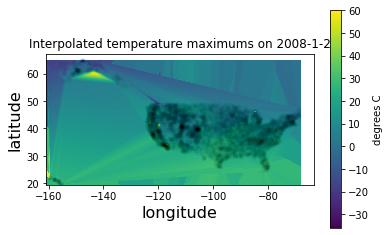

In [28]:
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
def est_weather_map_at(start_date, weather_val):
  mask = (precip_small['date'] >= start_date) & (precip_small['date'] < start_date + pd.Timedelta('7 days')) & (~precip_small[weather_val].isnull()) 
  mask = mask & (precip_small['lat'] > 19.5) & (precip_small['lat'] < 65) & (precip_small['long'] > -161.75583) & (precip_small['long'] < -68.01197)
  dat = precip_small.loc[mask]
  y = dat['lat']
  x = dat['long']
  z = dat[weather_val]
  
  if dat.shape[0] == 0:
    print(start_date)
    raise Exception("No weather data for the given date")

  xi = np.arange(-161, -68, .1)
  yi = np.arange(19.5, 65, .1)
  xi,yi = np.meshgrid(xi,yi)
  zi_fill = griddata((x,y),z,(xi,yi),method='nearest')
  zi = griddata((x,y),z,(xi,yi),method='linear')
  mask = np.isnan(zi)
  zi[mask] = zi_fill[mask]
  return xi, yi, zi, x, y, z
# Interpolate weather data
# target grid to interpolate to
#print(precip_small['TMAX'].unique())
plot_date = '2008-1-2'
xi, yi, zi, x, y, z = est_weather_map_at(pd.to_datetime(plot_date), 'TMAX')

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(x,y,'k.', alpha=0.01)
CS = plt.contourf(xi,yi,zi,100)
cbar = fig.colorbar(CS)
cbar.ax.set_ylabel('degrees C')
plt.title('Interpolated temperature maximums on ' + plot_date)
plt.xlabel('longitude',fontsize=16)
plt.ylabel('latitude',fontsize=16)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()
plt.close(fig)


def est_weather_val(lat, long, xi, yi, zi):
  # TODO this can be more efficient
  longs = xi[0]
  lats = yi[:, 0]

  ilong = (np.abs(longs - long)).argmin()
  ilat = (np.abs(lats - lat)).argmin()
  return zi[ilat, ilong]




In [29]:
print(est_weather_val(34.411667, -112.401667, xi, yi, zi))
def calc_weather(row, val='TMAX'):
  date = row['DISCOVERY_DATE'].iloc[0]
  xi, yi, zi, x, y, z = est_weather_map_at(date, val)
  return row.apply(lambda p: est_weather_val(p['LATITUDE'],p['LONGITUDE'], xi, yi, zi), axis=1)

# Make sure you remove all fires that are not during time periods we have weather data for.
last_weather_date = max(precip_small['date'])
first_weather_date = min(precip_small['date'])
df_test = df[(df['DISCOVERY_DATE'] < last_weather_date) & (df['DISCOVERY_DATE'] >= first_weather_date)].reset_index(drop=True)
print("Calculating weather for %d fires" % df_test.shape[0])
gb = df_test.groupby(pd.Grouper(key='DISCOVERY_DATE', freq='W'))
for col in ['TMAX', 'TMIN', 'PRCP', 'SNOW']:
  temp = gb.apply(calc_weather, val=col).transpose()
  df_test["ABS_" + col] = temp.reset_index(drop=True)
print(df_test[['LATITUDE', 'LONGITUDE', 'ABS_TMAX', 'ABS_TMIN', 'ABS_PRCP', 'ABS_SNOW']].head())
#df['TEMP_THIS_WEEK'] = df.apply(lambda r: , axis=1)

14.115586373585389
Calculating weather for 2021 fires
    LATITUDE   LONGITUDE   ABS_TMAX   ABS_TMIN   ABS_PRCP  ABS_SNOW
0  36.823611  -91.097778  18.045417 -13.333187   0.254360       0.0
1  36.412222  -82.192778  23.119393 -12.124576   0.000000       0.0
2  32.370833  -89.609444  14.682151   1.105341  38.489639       0.0
3  34.737222  -76.935556  18.526836  -6.142944   0.000000       0.0
4  34.374722 -118.398889  20.924266 -10.127005   0.000000       0.0


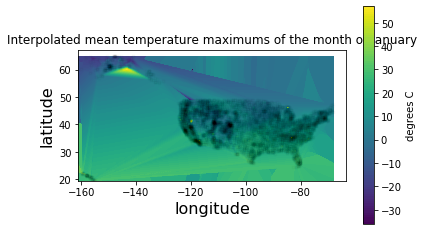

Calculating weather for 2021 fires
      month   LATITUDE   LONGITUDE   ABS_TMAX  MEAN_TMAX   ABS_PRCP  MEAN_PRCP
0         1  36.823611  -91.097778  18.045417  15.270643   0.254360   1.440389
1         1  36.412222  -82.192778  23.119393  13.002799   0.000000   8.980919
2         1  32.370833  -89.609444  14.682151  19.159736  38.489639   6.776955
3         1  34.737222  -76.935556  18.526836  24.010369   0.000000   6.164370
4         1  34.374722 -118.398889  20.924266  16.452151   0.000000   4.500217
...     ...        ...         ...        ...        ...        ...        ...
2016      1  21.320299 -157.852325  19.400000  27.286527   0.000000   1.580241
2017      1  20.877712 -156.473541   1.960132  25.850670   6.211445   9.665285
2018      1  20.907311 -156.416992   3.002839  25.037141   0.260905   2.653032
2019      1  20.925615 -156.301834   4.224747  21.247804   9.746064  14.559335
2020      1  20.909344 -156.291611   3.976399  21.247804  12.070152  14.559335

[2021 rows x 7 c

In [30]:
# Calculate yearwise means
station_monthly_means = precip_small.groupby(['station_id', precip_small.date.dt.month]) \
  .agg({'lat': 'mean', 'long' : 'mean', 'TMAX' : 'mean', 'TMIN': 'mean', 'PRCP': 'mean', 'SNOW': 'mean', 'SNWD': 'mean'}) \
  .reset_index().rename(columns={'date': 'month'})
df_test['month'] = df_test['DISCOVERY_DATE'].dt.month

def est_mean_weather_map_at(month, weather_val):
  mask = (station_monthly_means['month'] == month) & (~station_monthly_means[weather_val].isnull()) 
  mask = mask & (station_monthly_means['lat'] > 19.5) & (station_monthly_means['lat'] < 65) & (station_monthly_means['long'] > -161.75583) & (station_monthly_means['long'] < -68.01197)
  dat = station_monthly_means.loc[mask]
  y = dat['lat']
  x = dat['long']
  z = dat[weather_val]
  
  if dat.shape[0] == 0:
    print(month)
    raise Exception("No mean data for the given date")

  xi = np.arange(-161, -68, .1)
  yi = np.arange(19.5, 65, .1)
  xi,yi = np.meshgrid(xi,yi)
  zi_fill = griddata((x,y),z,(xi,yi),method='nearest')
  zi = griddata((x,y),z,(xi,yi),method='linear')
  mask = np.isnan(zi)
  zi[mask] = zi_fill[mask]
  return xi, yi, zi, x, y, z

xi, yi, zi, x, y, z = est_mean_weather_map_at(1, 'TMAX')

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(x,y,'k.', alpha=0.01)
CS = plt.contourf(xi,yi,zi,100)
cbar = fig.colorbar(CS)
cbar.ax.set_ylabel('degrees C')
plt.title('Interpolated mean temperature maximums of the month of January')
plt.xlabel('longitude',fontsize=16)
plt.ylabel('latitude',fontsize=16)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()
plt.close(fig)

def calc_weather_mean(row, val='TMAX'):
  month = row['month'].iloc[0]
  xi, yi, zi, x, y, z = est_mean_weather_map_at(month, val)
  return row.apply(lambda p: est_weather_val(p['LATITUDE'],p['LONGITUDE'], xi, yi, zi), axis=1)

last_weather_month = max(station_monthly_means['month'])
first_weather_month = min(station_monthly_means['month'])
df_test = df_test[(df_test['month'] <= last_weather_month) & (df_test['month'] >= first_weather_month)].reset_index(drop=True)
print("Calculating mean weather...")
gb = df_test.groupby('month')
for col in ['TMAX', 'TMIN', 'PRCP', 'SNOW']:
  temp = gb.apply(calc_weather_mean, val=col).transpose()
  df_test["MEAN_" + col] = temp.reset_index(drop=True)
print(df_test[['month', 'LATITUDE', 'LONGITUDE', 'ABS_TMAX', 'MEAN_TMAX', 'ABS_PRCP', 'MEAN_PRCP']].groupby(['LATITUDE', 'LONGITUDE', 'month']).head())


In [54]:
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor, BaggingRegressor, GradientBoostingRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from math import sqrt
 
models = [LinearRegression(), Lasso(), AdaBoostRegressor(), BaggingRegressor(), GradientBoostingRegressor()]
dfl2 = df_test
X = dfl2[["ABS_TMAX", "MEAN_TMAX", "ABS_PRCP", "MEAN_PRCP"]]
#X['ABS_TMAX'].fillna(, inplace=True)
X['DIFF_TMAX'] = X["ABS_TMAX"] - X['MEAN_TMAX']
X['FRAC_MEAN_PRCP'] = (X["ABS_PRCP"]/X['MEAN_PRCP']).fillna(0).replace(np.inf, 0)
#X = X.drop(['M'])
X# = pd.get_dummies(X, columns=["STAT_CAUSE_DESCR"], prefix=["cause"])

for col in X.columns:
  print(str(col) + ": " + str((X[col] > 1000).sum()))

y = dfl2["FIRE_SIZE"]
print("y: " + str(y.isnull().sum()))

print(X.head())
print(X.shape[0])
for model in models:
  scores = []
  rmss = []
  kfold = KFold(n_splits=3, shuffle=True, random_state=42)
  for i, (train, test) in enumerate(kfold.split(X, y)):
    model.fit(X.iloc[train], y.iloc[train])
    score = model.score(X.iloc[test], y.iloc[test])
    scores.append(score)
    y_predicted = model.predict(X.iloc[test])
    rmss.append(sqrt(mean_squared_error(y.iloc[test], y_predicted)))
 

  print(model)
  print("R^2:")
  print(scores)
  print("RMS:")
  print(rmss)

  print(models[0].coef_)
  top_i = np.abs(models[0].coef_).argsort()[-6:][::-1]
  print([x for x in zip(X.columns[top_i], models[0].coef_[top_i])])
  # Most

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


ABS_TMAX: 0
MEAN_TMAX: 0
ABS_PRCP: 0
MEAN_PRCP: 0
DIFF_TMAX: 0
FRAC_MEAN_PRCP: 14
y: 0
    ABS_TMAX  MEAN_TMAX   ABS_PRCP  MEAN_PRCP  DIFF_TMAX  FRAC_MEAN_PRCP
0  18.045417  15.270643   0.254360   1.440389   2.774774        0.176591
1  23.119393  13.002799   0.000000   8.980919  10.116594        0.000000
2  14.682151  19.159736  38.489639   6.776955  -4.477584        5.679488
3  18.526836  24.010369   0.000000   6.164370  -5.483533        0.000000
4  20.924266  16.452151   0.000000   4.500217   4.472115        0.000000
2021
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
R^2:
[-0.009522737669771741, 0.010326690719419496, 0.02368293776272468]
RMS:
[181.10446071848892, 294.3574474933935, 139.41220078689153]
[-2.95782249e+00 -3.00227879e+00 -4.28025011e-01 -4.13047561e+00
  4.44562963e-02 -3.38110198e-03]
[('MEAN_PRCP', -4.13047561249125), ('MEAN_TMAX', -3.0022787880394364), ('ABS_TMAX', -2.9578224917532507), ('ABS_PRCP', -0.4280250105961875), ('DIFF_TMAX',